## 1. Importing libraries

In [2]:
import pandas as pd
import numpy as np
import sys
sys.path.insert(0, './modules')
from Data_prep import Data
from Feature_engg import Feature_generator
import xgboost as xgb
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn import metrics
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
import warnings
warnings.filterwarnings('ignore')

## 2. Define parameters required to create data

In [3]:
#define number of processors to use for parallel runs
num_procs = 4

#set verbose level for models
verbose_lvl = 0

#define input files
train_feature_file = r'C:\Users\Admin\Desktop\salary_predictions\data\train_features.csv'
train_target_file = r'C:\Users\Admin\Desktop\salary_predictions\data\train_salaries.csv'
test_file = r'C:\Users\Admin\Desktop\salary_predictions\data\test_features.csv'

#define variables
cat_cols = ['companyId', 'jobType', 'degree', 'major', 'industry']
num_cols = ['yearsExperience', 'milesFromMetropolis']
target_col = 'salary'
id_col = 'jobId'

#turn feature engineering on/off
engineer_features = True

## 3. Creating a data object

In [5]:
data = Data(train_feature_file, train_target_file, test_file, cat_cols, num_cols, target_col, id_col)

## Taking a sample of the dataset due to computational limitations

In [6]:
data.train_df = data.train_df.sample(n = 10000,replace = True, random_state = 2)

In [7]:
if engineer_features:
    feature_generator = Feature_generator(data)
    feature_generator.add_group_stats()

In [5]:
data.train_df.shape

(10000, 15)

## 4. Train/test split

In [8]:
# Split Train/Test Set
X_train_2, X_test_2, y_train_2, y_test_2 = train_test_split(data.train_df.drop(["salary","index","jobId"], axis=1), data.train_df["salary"],random_state=10, test_size=0.25)

In [7]:
X_train_2.shape

(7500, 12)

## 5.Creating an evaluation set

In [9]:
# Create empty array to store results
results = []

# Create watchlist to keep track of train/validation performance
eval_set = [(X_train_2, y_train_2), (X_test_2, y_test_2)]

## 6. Tuning hyperparmeters using learning curves 
## 6.1 Tuning max_depth 

## The optimum max_depth is 4

In [9]:
for max_depth in [2,3,4,5,10,12,15]:
    clf = xgb.XGBRegressor(max_depth=max_depth)
    clf.fit(X_train_2, y_train_2, eval_set=eval_set, verbose=False)
    results.append(
        {
            'max_depth': max_depth,
            'train_error': metrics.mean_squared_error(y_train_2, clf.predict(X_train_2)),
            'test_error': metrics.mean_squared_error(y_test_2, clf.predict(X_test_2))
        })
    
# Display Results
max_depth_lr = pd.DataFrame(results).set_index('max_depth').sort_index()
max_depth_lr

,test_error,train_error
max_depth,,
2,71.374433,57.786998
3,61.607876,43.185711
4,60.725790,32.887048
5,66.088507,21.648123
10,82.024984,0.995045
12,78.392990,0.132293
15,78.151823,0.010131


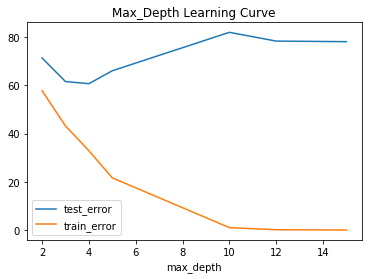

In [10]:
# Plot Max_Depth Learning Curve
max_depth_lr.plot(title="Max_Depth Learning Curve")

## 6.2 Tuning learning_rate 

## The best learning rate is 0.20

In [11]:
results = []

for learning_rate in [0.05,0.1,0.2,0.4,0.6,0.8,1]:
    clf = xgb.XGBRegressor(max_depth=2,learning_rate=learning_rate, n_estimators=200)
    clf.fit(X_train_2, y_train_2, eval_set=eval_set, verbose=False)
    results.append(
        {
            'learning_rate': learning_rate,
            'train_error': metrics.mean_squared_error(y_train_2, clf.predict(X_train_2)),
            'test_error': metrics.mean_squared_error(y_test_2, clf.predict(X_test_2))
        })
    
learning_rate_lr = pd.DataFrame(results).set_index('learning_rate').sort_index()
learning_rate_lr

,test_error,train_error
learning_rate,,
0.05,71.171627,56.999398
0.10,68.488581,51.934373
0.20,64.080710,44.530644
0.40,64.540460,38.432027
0.60,68.679947,35.996378
0.80,68.192932,32.510420
1.00,72.624001,32.617701


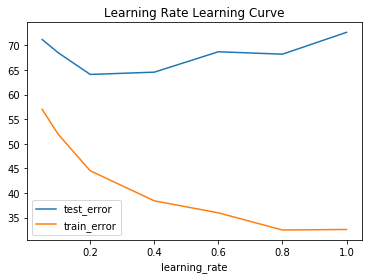

In [12]:
# Plot Learning Rate
learning_rate_lr.plot(title="Learning Rate Learning Curve")

## 6.3 Tuning N_estimators

## The optimum number of estimators is 500

In [13]:
# Reset results array
results = []

for n_estimators in [50,60,100,150,200,500,750,1000, 1500]:
    clf = xgb.XGBRegressor(max_depth=2,learning_rate=0.10, n_estimators=n_estimators)
    clf.fit(X_train_2, y_train_2, eval_set=eval_set, verbose=False)
    results.append(
        {
            'n_estimators': n_estimators,
            'train_error': metrics.mean_squared_error(y_train_2, clf.predict(X_train_2)),
            'test_error': metrics.mean_squared_error(y_test_2, clf.predict(X_test_2))
        })
    
n_estimators_lr = pd.DataFrame(results).set_index('n_estimators').sort_index()
n_estimators_lr

,test_error,train_error
n_estimators,,
50,87.267849,73.466090
60,79.690881,66.578145
100,71.374433,57.786998
150,70.069266,54.768310
200,68.488581,51.934373
500,60.978052,41.610912
750,61.794443,38.553389
1000,62.261050,36.208002
1500,63.969600,33.078236


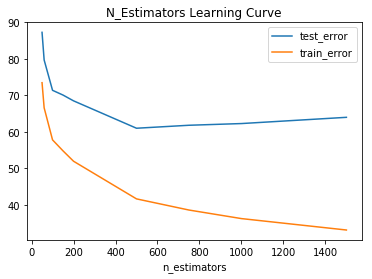

In [14]:
n_estimators_lr.plot(title="N_Estimators Learning Curve")

## 7. Perform grid_search

In [15]:
model = xgb.XGBRegressor()

In [16]:
# Define Parameters
param_grid = {"max_depth": [3,4,5],
              "max_features" : [1,0.8],
              "min_samples_leaf" : [5,9],
              "n_estimators": [450,500,600],
              "learning_rate": [0.1,0.2,0.3]}

In [17]:
# Perform Grid Search CV
gs_cv = GridSearchCV(model, param_grid=param_grid, cv = 3, verbose=10, n_jobs=-1 ).fit(X_train_2, y_train_2)

Fitting 3 folds for each of 108 candidates, totalling 324 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    6.3s
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    8.9s
[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:   10.9s
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:   15.4s
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:   19.3s
[Parallel(n_jobs=-1)]: Done  45 tasks      | elapsed:   24.3s
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:   29.3s
[Parallel(n_jobs=-1)]: Done  69 tasks      | elapsed:   37.1s
[Parallel(n_jobs=-1)]: Done  82 tasks      | elapsed:   45.2s
[Parallel(n_jobs=-1)]: Done  97 tasks      | elapsed:   57.0s
[Parallel(n_jobs=-1)]: Done 112 tasks      | elapsed:  1.1min
[Parallel(n_jobs=-1)]: Done 129 tasks      | elapsed:  1.2min
[Parallel(n_jobs=-1)]: Done 146 tasks      | elapsed:  1.4min
[Parallel(n_jobs=-1)]: Done 165 tasks      | elapsed:  1.6min
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:  1

In [18]:
# Best hyperparmeter setting
gs_cv.best_estimator_

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, learning_rate=0.1, max_delta_step=0,
       max_depth=3, max_features=1, min_child_weight=1, min_samples_leaf=5,
       missing=None, n_estimators=450, n_jobs=1, nthread=None,
       objective='reg:linear', random_state=0, reg_alpha=0, reg_lambda=1,
       scale_pos_weight=1, seed=None, silent=True, subsample=1)

## 8. Use the best model

In [10]:
# Use our best model parameters found by GridSearchCV
best_model = xgb.XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, learning_rate=0.1, max_delta_step=0,
       max_depth=3, max_features=1.0, min_child_weight=1,
       min_samples_leaf=5, missing=None, n_estimators=450, n_jobs=1,
       nthread=None, objective='reg:linear', random_state=0, reg_alpha=0,
       reg_lambda=1, scale_pos_weight=1, seed=None, silent=True,
       subsample=1)

## 9. Plot learning curve

Text(0.5, 1.0, 'XGBoost RMSE')

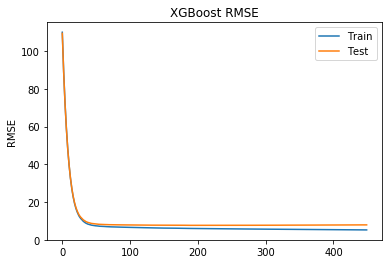

In [20]:
# Create eval_set
eval_set = [(X_train_2, y_train_2), (X_test_2, y_test_2)]

# Fit our model to the training set
best_model.fit(X_train_2, y_train_2, eval_set=eval_set, verbose=False)

# Make predictions with test data
y_pred = best_model.predict(X_test_2)
predictions = [round(value) for value in y_pred]

# Retrieve performance metrics
results = best_model.evals_result()
epochs = len(results['validation_0']['rmse'])
x_axis = range(0, epochs)

# Plot log loss curve
fig, ax = plt.subplots()
ax.plot(x_axis, results['validation_0']['rmse'], label='Train')
ax.plot(x_axis, results['validation_1']['rmse'], label='Test')
ax.legend()
plt.ylabel('RMSE')
plt.title('XGBoost RMSE')

## 10. Early stopping

In [11]:
best_model.fit(X_train_2, y_train_2, early_stopping_rounds=10, eval_set=eval_set, verbose=True)

[0]	validation_0-rmse:109.845	validation_1-rmse:109.577
Multiple eval metrics have been passed: 'validation_1-rmse' will be used for early stopping.

Will train until validation_1-rmse hasn't improved in 10 rounds.
[1]	validation_0-rmse:99.0021	validation_1-rmse:98.7209
[2]	validation_0-rmse:89.2478	validation_1-rmse:88.9548
[3]	validation_0-rmse:80.4795	validation_1-rmse:80.1827
[4]	validation_0-rmse:72.594	validation_1-rmse:72.2894
[5]	validation_0-rmse:65.5117	validation_1-rmse:65.2294
[6]	validation_0-rmse:59.146	validation_1-rmse:58.8527
[7]	validation_0-rmse:53.4323	validation_1-rmse:53.1374
[8]	validation_0-rmse:48.3054	validation_1-rmse:48.0121
[9]	validation_0-rmse:43.7086	validation_1-rmse:43.4277
[10]	validation_0-rmse:39.5926	validation_1-rmse:39.3241
[11]	validation_0-rmse:35.9106	validation_1-rmse:35.646
[12]	validation_0-rmse:32.6211	validation_1-rmse:32.3639
[13]	validation_0-rmse:29.6841	validation_1-rmse:29.4604
[14]	validation_0-rmse:27.0663	validation_1-rmse:26.8663

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, learning_rate=0.1, max_delta_step=0,
       max_depth=3, max_features=1.0, min_child_weight=1,
       min_samples_leaf=5, missing=None, n_estimators=450, n_jobs=1,
       nthread=None, objective='reg:linear', random_state=0, reg_alpha=0,
       reg_lambda=1, scale_pos_weight=1, seed=None, silent=True,
       subsample=1)